# 2. Evaluating Mayinga assemblies

> evaluating polishing strategies for de novo vs. reference guided assemblies, as well evaluating fast vs. high accuracy basecalling

***

## Overview

* calculate consensus identity

* check structural and nucleotide differences

***

**TODO**

1. colour snps in MSA viewer
2. filter coverage for nucfdiff - e.g. only check differences in areas where coverage > 50x

***

## Consensus identity

Grab the mayinga reference genome:

In [160]:
!find ./ -name GCF_000848505.1_ViralProj14703_genomic.fna.gz -exec gunzip -c {} + > tmp/mayinga-ref-genome.fasta

Collect all the mayinga assemblies from the pipeline outputs (for both fast and hac):

In [161]:
# get a file list of all the polished assemblies we just made, one for fast basecalls and one for hac
!find $PWD/pipelines/data/pipeline-results/r941_min_fast/*-assembly/*barcode-09*.fasta > tmp/mayinga-assemblies_fast.list
!find $PWD/pipelines/data/pipeline-results/r941_min_hac/*-assembly/*barcode-09.*.fasta > tmp/mayinga-assemblies_hac.list

Calculate the consensus identity for each Mayinga sample compared to the reference:

* this can be calculated from columns 10 and 11 of a PAF alignment file
* [hengi li's take on sequence identity](https://lh3.github.io/2018/11/25/on-the-definition-of-sequence-identity)

In [162]:
# import the minimap2 binding (mappy)
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import mappy as mp

def plotConsensusIdentity(assemblyList):
    
    # set up the results list
    idents = []

    # set up the index
    a = mp.Aligner("tmp/mayinga-ref-genome.fasta", preset="asm10")  # load or build index
    if not a: raise Exception("ERROR: failed to load/build index")

    # open the list of assemblies we made
    with open(assemblyList, "r") as fh:

        # align each assembly to the reference
        for line in fh:
            base=os.path.basename(line)
            assemblyName=os.path.splitext(base)[0]
            for name, seq, qual in mp.fastx_read(line.rstrip()):

                # get the best hit for each assembly
                topHit = 0.0
                for hit in a.map(seq):
                    if (hit.mlen/hit.blen) > topHit:
                        topHit = (hit.mlen/hit.blen) * 100.0

                # store for plotting later
                idents.append([assemblyName, topHit])

    # plot the consensus identities
    df = pd.DataFrame(idents, columns = ['Assembly', 'Consensus Identity']) 
    chart = sns.barplot(x="Assembly", y="Consensus Identity", data=df)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
    chart.set(ylim=(90, 100))
    chart

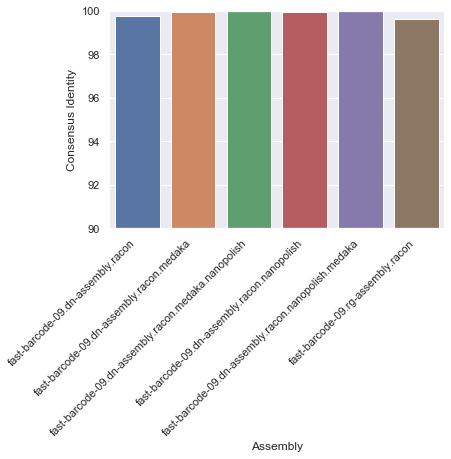

In [163]:
plotConsensusIdentity("tmp/mayinga-assemblies_fast.list")

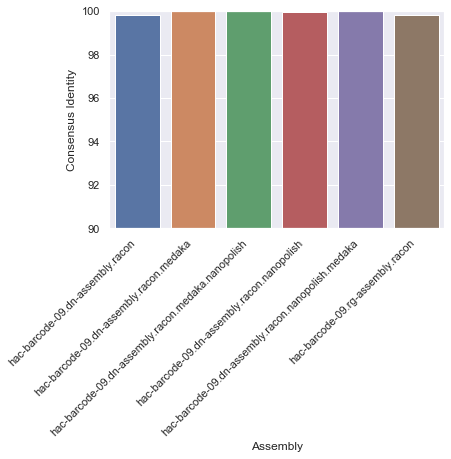

In [164]:
plotConsensusIdentity("tmp/mayinga-assemblies_hac.list")

## Structural and nucleotide differences

Use NucDiff to get some stats on SNPs, InDels and rearrangements:

In [165]:
import subprocess
import glob
from tabulate import tabulate

# given a list of assemblies and output dir, run nucdiff
def runNucdiff(assemblyList, outDir):
    with open(assemblyList, 'r') as fh:
        # parse the assembly name to get the output filename
        for line in fh:
            assembly = line.rstrip("\n")
            name = ""
            if "dn-" in assembly:
                name = "dn"
            elif "rg-" in assembly:
                name = "rg"
            elif "ref-" in assembly:
                name = "var"
            else:
                continue
            if name == "var":
                polishing = assembly.split(".ref-alignment")[-1]
                name += polishing.replace(".fasta", "", 1)                
            else:
                polishing = assembly.split(".racon")[-1]
                name += polishing.replace(".fasta", "", 1)
            
            # run nucdiff
            cmd = ["nucdiff", "tmp/mayinga-ref-genome.fasta", assembly, outDir, name]
            process = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, universal_newlines=True)

            
# parse nucdiff output to get SNPs and InDels
def parseNucDiff(nucdiffOutdir):
    nucdiffFiles = [i for i in glob.glob(nucdiffOutdir + "/results/*_stat.out")]
    nucdiffFiles.sort()
    dfs = []
    for f in nucdiffFiles:
        fn = os.path.basename(f).replace('_stat.out', '')
        df = pd.read_csv(f, sep='\t', header=None, index_col=0)
        df.columns = [fn]
        dfs.append(df)
    combined = pd.concat(dfs, axis=1, sort=False)
    #stats = combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions', 'Uncovered ref regions num', 'Uncovered ref regions len'] , : ]
    
    table = combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions'] , : ]
    print(tabulate(table, headers='keys', tablefmt='psql'))

In [166]:
print("fast basecalling:")
runNucdiff("tmp/mayinga-assemblies_fast.list", "tmp/fast")
parseNucDiff("tmp/fast")

fast basecalling:
+---------------+------------------------+-------------+------------------------+-----------------+------+------+
| 0             |   dn.medaka.nanopolish |   dn.medaka |   dn.nanopolish.medaka |   dn.nanopolish |   dn |   rg |
|---------------+------------------------+-------------+------------------------+-----------------+------+------|
| Total number  |                      3 |           6 |                      5 |              15 |   40 |   52 |
| Insertions    |                      1 |           1 |                      1 |               3 |   18 |   24 |
| Deletions     |                      1 |           4 |                      3 |              11 |   21 |   26 |
| Substitutions |                      1 |           1 |                      1 |               1 |    1 |    2 |
+---------------+------------------------+-------------+------------------------+-----------------+------+------+


In [167]:
print("high accuracy basecalling:")
runNucdiff("tmp/mayinga-assemblies_hac.list", "tmp/hac")
parseNucDiff("tmp/hac")

high accuracy basecalling:
+---------------+------------------------+-------------+------------------------+-----------------+------+------+
| 0             |   dn.medaka.nanopolish |   dn.medaka |   dn.nanopolish.medaka |   dn.nanopolish |   dn |   rg |
|---------------+------------------------+-------------+------------------------+-----------------+------+------|
| Total number  |                      4 |           3 |                      3 |               9 |   25 |   26 |
| Insertions    |                      1 |           2 |                      2 |               2 |   15 |   15 |
| Deletions     |                      0 |           0 |                      0 |               4 |    8 |   10 |
| Substitutions |                      3 |           1 |                      1 |               3 |    2 |    1 |
+---------------+------------------------+-------------+------------------------+-----------------+------+------+


Now check the variant calling approach:

In [168]:
!find $PWD/pipelines/data/pipeline-results/r941_min_fast/*-alignment/*barcode-09*.fasta > tmp/mayinga-variant-calling_fast.list
!find $PWD/pipelines/data/pipeline-results/r941_min_hac/*-alignment/*barcode-09*.fasta > tmp/mayinga-variant-calling_hac.list

In [169]:
print("fast basecalling:")
runNucdiff("tmp/mayinga-variant-calling_fast.list", "tmp/fast-variants")
parseNucDiff("tmp/fast-variants")

fast basecalling:
+---------------+--------------+------------------+
| 0             |   var.medaka |   var.nanopolish |
|---------------+--------------+------------------|
| Total number  |            1 |               15 |
| Insertions    |            0 |                2 |
| Deletions     |            0 |                0 |
| Substitutions |            1 |               13 |
+---------------+--------------+------------------+


In [170]:
print("high accuracy basecalling:")
runNucdiff("tmp/mayinga-variant-calling_hac.list", "tmp/hac-variants")
parseNucDiff("tmp/hac-variants")

high accuracy basecalling:
+---------------+--------------+------------------+
| 0             |   var.medaka |   var.nanopolish |
|---------------+--------------+------------------|
| Total number  |            1 |               27 |
| Insertions    |            0 |                0 |
| Deletions     |            0 |                0 |
| Substitutions |            1 |               27 |
+---------------+--------------+------------------+


Now let's create a multiple sequence alignment to visualise the differences:
* use sed to label each fasta header in the assemblies with the basecalling model

In [3]:
!cp tmp/mayinga-ref-genome.fasta tmp/mayinga-assemblies.fasta
!sed s/contig/fast-/ pipelines/data/pipeline-results/r941_min_fast/*-assembly/*barcode-09*assembly.racon*fasta >> tmp/mayinga-assemblies.fasta
!sed s/contig/hac-/ pipelines/data/pipeline-results/r941_min_hac/*-assembly/*barcode-09*assembly.racon*fasta >> tmp/mayinga-assemblies.fasta

In [4]:
# generate a multiple sequence alignment using Muscle
from Bio.Align.Applications import MuscleCommandline
muscle_cmd = MuscleCommandline(input = "tmp/mayinga-assemblies.fasta", out = "tmp/mayinga-assembly-alignment.msa", clw=True)
muscle_cmd()

('',
 '\nMUSCLE v3.8.1551 by Robert C. Edgar\n\nhttp://www.drive5.com/muscle\nThis software is donated to the public domain.\nPlease cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.\n\nmayinga-assemblies 13 seqs, lengths min 18904, max 18977, avg 18927\n00:00:00      3 MB(0%)  Iter   1    1.10%  K-mer dist pass 1\n00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1\n00:00:00      3 MB(0%)  Iter   1    1.10%  K-mer dist pass 2\n00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2\n00:00:00     63 MB(0%)  Iter   1    8.33%  Align node       \n00:00:04    450 MB(3%)  Iter   1   16.67%  Align node\n00:00:08    455 MB(3%)  Iter   1   25.00%  Align node\n00:00:12    461 MB(3%)  Iter   1   33.33%  Align node\n00:00:15    478 MB(3%)  Iter   1   41.67%  Align node\n00:00:19    483 MB(3%)  Iter   1   50.00%  Align node\n00:00:23    489 MB(3%)  Iter   1   58.33%  Align node\n00:00:26    495 MB(3%)  Iter   1   66.67%  Align node\n00:00:30    501 MB(3%)  Iter   1   75.00%  Align

In [5]:
# print using BioPython
from Bio import AlignIO
alignment = AlignIO.read("tmp/mayinga-assembly-alignment.msa", "clustal")
print(alignment.format("clustal"))

CLUSTAL X (3.8) multiple sequence alignment


assembly.raw.fast-1                 --------------------------------------------------
nanopolish.fast-1                   --------------------------------------------------
assembly.raw.hac-1                  --------------------------------------------------
barcode-09---NC_002549.1            CGGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGAATA
medaka.nanopolish.hac-1             --------------------------------------------------
nanopolish.hac-1                    --------------------------------------------------
medaka.fast-1                       --------------------------------------------------
nanopolish.medaka.fast-1            --------------------------------------------------
medaka.nanopolish.fast-1            --------------------------------------------------
medaka.hac-1                        --------------------------------------------------
nanopolish.medaka.hac-1             ------------------------------------------------

In [ ]:
from Bio.Align import AlignInfo
summary = AlignInfo.SummaryInfo(alignment)